In [16]:
import numpy as np
import pandas as pd
%matplotlib inline
# for plotting
import seaborn as sns
sns.set(style='white', font_scale=1.5)
#for working with Bam files
import pysam
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import math

from mpl_toolkits.mplot3d import Axes3D

In [17]:
cd /broad/mushroom_lasagna/YB/Ht115_new_samples/

/broad/mushroom_lasagna/YB/Ht115_new_samples


In [19]:
full_mut = pd.read_pickle('HT115_full_mutations.pkl') #the pkl file from step on1
#full_mut = pd.read_pickle('RPE1_full_mutations.pkl') #the pkl file from step on1
print full_mut.shape

(64770, 7)


In [20]:
# Just for HT115: cut out the outer sample (#37) before calculateing clusters:
ft = full_mut
t_full_data=[]
for ind in ft.index:
    temp=ft.full_data[ind]
    for line in temp:
        if line[0]=="HT6W37":
            temp.remove(line)
    t_full_data.append(temp)

ft['full_data']= t_full_data    
full_mut=ft
full_mut[0:3]

,contig,position,context,ref_all,alt_all,t_lod_fstar,full_data
0,1,1131218,TCTxCCT,C,T,7.952986,"[(HT6W45, : , [0, 0, 47, 0], , [0.0, 0.0, 1.0..."
1,1,1531286,ACAxAGA,C,G,6.839665,"[(HT6W45, : , [0, 0, 32, 2], , [0.0, 0.0, 0.9..."
2,1,1894948,AAAxAAA,C,A,7.705098,"[(HT6W45, : , [3, 0, 40, 1], , [0.06818181818..."


In [21]:
#function that get ratio vector from all the samples and return vector of clustering
#Cluster by hirarchical algorithm
def into_vector(fd,ref,alt):#'ATCG'
    c1=[]
    for i in fd:
        #value=float(i[2][alt])/(i[2][ref]+i[2][alt])
        #c1.append([i[2][alt],i[2][ref]])
        c1.append([i[4][alt],i[4][ref]])
    Z = linkage(c1, 'ward')
    k=2
    cluster=fcluster(Z, k, criterion='maxclust')
    dist= max(Z[:,2])
    return (cluster,Z,dist)

#this function calculate the allele fraction in th
def af_taker(fd,ref,alt,vec):
     return (fd)   
 
#print the dendrogram
def dendo_pr(Z):
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=26.,  # font size for the x axis labels
    labels=imp
    )
    return Z

# This function check if one of the samples has length of 
def chk_len(a,thr):
    flag=1
    for j in a:
        #print j[2], "and it sum ",sum(j[2])
        if sum(j[2])<thr:
            flag=0
    return flag

#this function gets avector (binary) and make ones to be the smallest group
def smallest_group_vector(vec):
    vec = list(vec)
    if vec.count(0)<vec.count(1):
        vec2=1-np.array(vec)
    else:
        vec2=np.array(vec)
    return vec2


#build the vector from nucleotides
def convert_letter(char):#'ATCG'
    if char=="A":
        ans=0
    elif char=="T":
        ans=1
    elif char=="C":
        ans=2
    elif char=="G":
        ans=3
    else:
        ans=-1
    return ans


In [22]:
#drop samples with less than 10 covering deapth
#calculate the vectors (clustering for all the data)
cmut=full_mut
#print cmut.shape
flist=[]
drop_count=0
thr=5 #length threshold (if one of the samples have less than this threshold, we will not use it
#thr=0
for ind in cmut.index:
    a=cmut.full_data[ind]
    if chk_len(a,thr)==1:
        ref=convert_letter(cmut.ref_all[ind])
        alt=convert_letter(cmut.alt_all[ind])
        vec,z,dist=into_vector(a,ref,alt)#'ATCG'
        vec=vec-1
        vec=smallest_group_vector(vec)
        v1 =vec.astype(int)
        v1 =int(''.join(map(str,v1)))
        #af = af_taker(a,ref,alt,vec)#
        cmut.set_value(index=ind,col='vector',value=v1)
        cmut.set_value(index=ind,col='Z_dist',value=dist)
    elif chk_len(a,thr)==0:
        #print "drop out",ind
        drop_count=drop_count+1
        cmut = cmut.drop(ind)
        
print "dropped out ",drop_count, "rows, that one of the samples contains less than ",thr ," reads deapth"
#cmut.to_pickle('/broad/mushroom_lasagna/YB/Ht115_new_samples/Hirch_06112017.pkl') 

/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


dropped out  130 rows, that one of the samples contains less than  5  reads deapth


In [23]:
#this function gets a vector (binary) make ones to be the smallest group
def arrange_group_in_vector(vec):
    vec = list(vec)
    nvec=np.zeros(len(vec))
    lim=max(vec)+1
    arr=[]
    for i in range(lim):
        arr.append(vec.count(i))  
    arr =(sorted(range(len(arr)), key=lambda k: arr[k]))
    arr =list(reversed(arr))
    
    # arr is the array of values sorted by order
    index=0
    for i in arr:
        for k in ([j for j,x in enumerate(vec) if x == i]):
            nvec[k]=index
        index=index+1

    #for i in range(len(arr)):
    #    print [j for j,x in enumerate(arr) if x == i]
    return nvec


#show specific lines
def present(mut,ind):
    for i in mut.loc[ind].full_data :
        print i[0],i[2]
    return

def vec_from_int_to_list(vec,size):
    vec = map(int, str(vec))
    nvec=[0]*(size-len(vec))
    nvec=nvec+vec
    return nvec

#choose r out of n
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

#build the vector from nucleotides
def convert_ind(ini):#'ATCG'
    if ini==0:
        ans="A"
    elif ini==1:
        ans="T"
    elif ini==2:
        ans="C"
    elif ini==3:
        ans="G"
    else:
        ans=-1
    return ans

In [24]:
#just update the ref and alt
#####calculate probability to belong the group:
#1. find ceneter of cluster, and for each point put in the closets position
#2. give mark of spreadness for both clusters
def Clean_cluster (fdata,vec):
    ind=0
    x1=[]
    x2=[]
    x3=[]
    x4=[]
    #for i in spot.Seq:
    for line in fdata:
        points=line[2]+1 #the precentage data
        #print points
        points=points.astype(float)/sum(points)
        #print points
        #points=print_counts(i)
        #points=pre_seq(i) #on the precentage table
        x1.append(points[0])
        x2.append(points[1])
        x3.append(points[2])
        x4.append(points[3])
        
    cg1x1=np.sum(np.array(x1)*np.array(vec))/(np.sum(np.array(vec)))
    cg1x2=np.sum(np.array(x2)*np.array(vec))/(np.sum(np.array(vec)))
    cg1x3=np.sum(np.array(x3)*np.array(vec))/(np.sum(np.array(vec)))
    cg1x4=np.sum(np.array(x4)*np.array(vec))/(np.sum(np.array(vec)))
    
    vec2=1-np.array(vec)
    
    cg2x1=np.sum(np.array(x1)*np.array(vec2))/(np.sum(np.array(vec2)))
    cg2x2=np.sum(np.array(x2)*np.array(vec2))/(np.sum(np.array(vec2)))
    cg2x3=np.sum(np.array(x3)*np.array(vec2))/(np.sum(np.array(vec2)))
    cg2x4=np.sum(np.array(x4)*np.array(vec2))/(np.sum(np.array(vec2)))
    
    #print "cg1",cg1x1,",",cg1x2,",",cg1x3,",",cg1x4,"  cg2:",cg2x1,",",cg2x2,",",cg2x3,",",cg2x4
    #cg2-> changed into cg1
    cg1=[cg1x1,cg1x2,cg1x3,cg1x4]
    cg2=[cg2x1,cg2x2,cg2x3,cg2x4]
    ccg=np.array(cg2)-np.array(cg1)
    #print "ccg: ",ccg
    #ref_all=np.where(np.array(cg2)==np.array(cg2).max())[0][0]
    ref_all=np.where(ccg==ccg.max())[0][0]
    alt_all=np.where(ccg==ccg.min())[0][0]
    #print "ref:",ref_all," alt:", alt_all

    
    altAF=[]
    refAF=[]
    index=0
    #for i in spot.Seq:
    ###########################################
    ###########################################
    ##  AND take out 37 from the average
    ###########################################
    ###########################################
    for line in fdata:
        tt= line[2]
        if (index!=1):
            if vec[index]==1:#if it belong to the mutated
                altAF.append(float(tt[alt_all])/sum(tt))
                #print "line: ",tt," = alt ",float(tt[alt_all])/sum(tt)
            else:
                refAF.append(float(tt[ref_all])/sum(tt))
                #print "line: ",tt," = ref ",float(tt[ref_all])/sum(tt)
        index+=1
    #print "mean altAF:",np.mean(altAF)
    #print "mean refAF:",np.mean(refAF)
    
    alt_af=np.mean(altAF)
    ref_af=np.mean(refAF)
    
    # now for each sample calculate the chance to belong to both groups
    #for line in fdata:
    
        
    samp=0
    chance=[]
    for line in fdata:
        #print "bef ",line[2]
        #points=line[2] #now I consider the actual deapth for precentage calculations 
        points=line[2]+1 #now I consider the actual deapth for precentage calculations 
        #print "after ",points
        
        p1=1
        p2=1
        count=alt_all
        #for nn in cg1:
        #if (points[count]!=0):
            
        p1=p1*((nCr(sum(points),points[count])) * (cg1[count]**points[count]) *((1-cg1[count])**(sum(points)-points[count])))
        p2=p2*((nCr(sum(points),points[count])) * (cg2[count]**points[count]) *((1-cg2[count])**(sum(points)-points[count])))
        
        count=ref_all
        p1=p1*((nCr(sum(points),points[count])) * (cg1[count]**points[count]) *((1-cg1[count])**(sum(points)-points[count])))
        p2=p2*((nCr(sum(points),points[count])) * (cg2[count]**points[count]) *((1-cg2[count])**(sum(points)-points[count])))

        #print "p1: ",p1
        #print "p2: ",p2
        
        if vec[samp]==1:
            #if p1==0:
            #    tch=-10 #((p1/p2))
            #else:
            #    tch=(math.log(p1/p2))
            tch=p1/(p1+p2)
            #chance.append(math.log(p1)/math.log(p2))
        else:
            #if p2==0:
            #    tch=-10 #((p1/p2))
            #else:
            #    tch=(math.log(p2/p1)) 
            tch=p2/(p1+p2)
            #chance.append(math.log(p2)/math.log(p1))
        if np.isnan(tch):
            tch=np.nan_to_num(tch)
        chance.append(tch)
            
        #print line[0],": p1 =",p1," p2=",p2
        #print line[0],": ratio: ",chance[samp]
        samp=samp+1
    #print "Min chance: ",min(chance)
    return chance,ref_af,alt_af,ref_all,alt_all
 

In [25]:
count=0
events=0
for ind in cmut.index: #convert vec from int to 
    vec=int(cmut.vector[ind])
    nvec=vec_from_int_to_list(vec,len(cmut.full_data[ind]))
    fdata=cmut.full_data[ind]
    chance,ref_af,alt_af,ref_all,alt_all = np.array(Clean_cluster(fdata,nvec))
    cmut.set_value(index=ind,col='ref_af',value=ref_af)
    cmut.set_value(index=ind,col='alt_af',value=alt_af)
    cmut.set_value(index=ind,col='ref_all',value=ref_all)
    cmut.set_value(index=ind,col='alt_all',value=alt_all)
    cmut.set_value(index=ind,col='Min_prob',value=np.min(chance))
    count+=1
    if (count%1000==0):
        print "did ",count
    
    
#cmut.to_pickle('/broad/mushroom_lasagna/YB/Ht115_new_samples/new_corr_Hirch_mark.pkl') 
print "finito ",count

/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back b

did  1000
did  2000
did  3000
did  4000
did  5000
did  6000
did  7000
did  8000
did  9000
did  10000
did  11000
did  12000
did  13000
did  14000
did  15000
did  16000
did  17000
did  18000
did  19000
did  20000
did  21000
did  22000
did  23000
did  24000
did  25000
did  26000
did  27000
did  28000
did  29000
did  30000
did  31000
did  32000
did  33000
did  34000
did  35000
did  36000
did  37000
did  38000
did  39000
did  40000
did  41000
did  42000
did  43000
did  44000
did  45000
did  46000
did  47000
did  48000
did  49000
did  50000
did  51000
did  52000
did  53000
did  54000
did  55000
did  56000
did  57000
did  58000
did  59000
did  60000
did  61000
did  62000
did  63000
did  64000
finito  64640


In [26]:
#build the vector from nucleotides
def convert_ind(ini):#'ATCG'
    if ini==0:
        ans="A"
    elif ini==1:
        ans="T"
    elif ini==2:
        ans="C"
    elif ini==3:
        ans="G"
    else:
        ans=-1
    return ans

for ind in cmut.index:
    value = convert_ind(cmut.alt_all[ind])
    cmut.set_value(index=ind,col='alt_all',value=value)
    value = convert_ind(cmut.ref_all[ind])
    cmut.set_value(index=ind,col='ref_all',value=value)
cmut[0:3] 

/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,contig,position,context,ref_all,alt_all,t_lod_fstar,full_data,vector,Z_dist,ref_af,alt_af,Min_prob
0,1,1131218,TCTxCCT,C,T,7.952986,"[(HT6W45, : , [0, 0, 47, 0], , [0.0, 0.0, 1.0...",1.000000e+05,0.181252,0.997531,0.096154,0.666256
1,1,1531286,ACAxAGA,C,G,6.839665,"[(HT6W45, : , [0, 0, 32, 2], , [0.0, 0.0, 0.9...",1.000011e+09,0.359299,0.884470,0.219048,0.681843
2,1,1894948,AAAxAAA,A,C,7.705098,"[(HT6W45, : , [3, 0, 40, 1], , [0.06818181818...",1.010000e+09,0.233787,0.105038,0.961905,0.486027


## Perform the conversion of the first branch:

In [27]:
# now retrive the original outer sample (#37):
ref=pd.read_pickle('HT115_full_mutations.pkl') #the pkl file from step on1
print ref.shape
print cmut.shape


(64770, 7)
(64640, 12)


In [28]:
def convert_all(ini):#'ATCG'
    if ini=="A":
        ans=0
    elif ini=="T":
        ans=1
    elif ini=="C":
        ans=2
    elif ini=="G":
        ans=3
    else:
        ans=-1
    return ans
    

In [29]:
sw=0
for ind in cmut.index:
    if (cmut.vector[ind]==1001000000): #if its #54+47
        #check for 37
        allele=convert_all(cmut.alt_all[ind])
        c37= ref.full_data[ind][0][6][allele]
        if c37==1:
            if ref.position[ind] != cmut.position[ind]:
                print "Bad"
            cmut.set_value(ind,'vector',10110111111)
            temp=cmut.ref_all[ind]
            cmut.set_value(ind,'ref_all',cmut.alt_all[ind])
            cmut.set_value(ind,'alt_all',temp)
            temp=cmut.ref_af[ind]
            cmut.set_value(ind,'ref_af',cmut.alt_af[ind])
            cmut.set_value(ind,'alt_af',temp)
            sw+=1
print "switched ",sw
        

/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipyke

switched  176


In [30]:
klist=[]
print "before:",cmut.shape
for ind in cmut.index: #convert vec from int to 
    vec=int(cmut.vector[ind])
    nvec=vec_from_int_to_list(vec,len(cmut.full_data[ind]))
    if sum(nvec)>1: #drop single mutations
        klist.append(ind)
keep = cmut.ix[klist]
keep=keep.reset_index()
keep=keep.drop_duplicates(['position','contig'])
print "only groups (branches):",keep.shape
#keep=keep.drop_duplicates(['position'])
keep=keep[keep.Min_prob>0.99]
print "grade filter:",keep.shape
keep= keep[(keep.ref_af>0.85) | (keep.alt_af<0.85)]
print "AF filter:",keep.shape

before: (64640, 12)
only groups (branches): (41434, 13)
grade filter: (3515, 13)
AF filter: (3009, 13)


/broad/blainey_lab/blainey-ipython/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### Plot Figure 4 b:

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]  :  810
[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]  :  403
[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]  :  318
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]  :  316
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]  :  293
[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]  :  171
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]  :  168
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  :  151
[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]  :  142
[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]  :  14
[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]  :  6
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]  :  5
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]  :  4
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]  :  4
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  :  4
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]  :  3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]  :  3
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]  :  3
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]  :  3
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]  :  3
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]  :  3
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]  :  3
[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]  :  2
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]  :  2
[0, 0, 1, 1, 0, 0, 0,

/broad/blainey_lab/blainey-ipython/packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


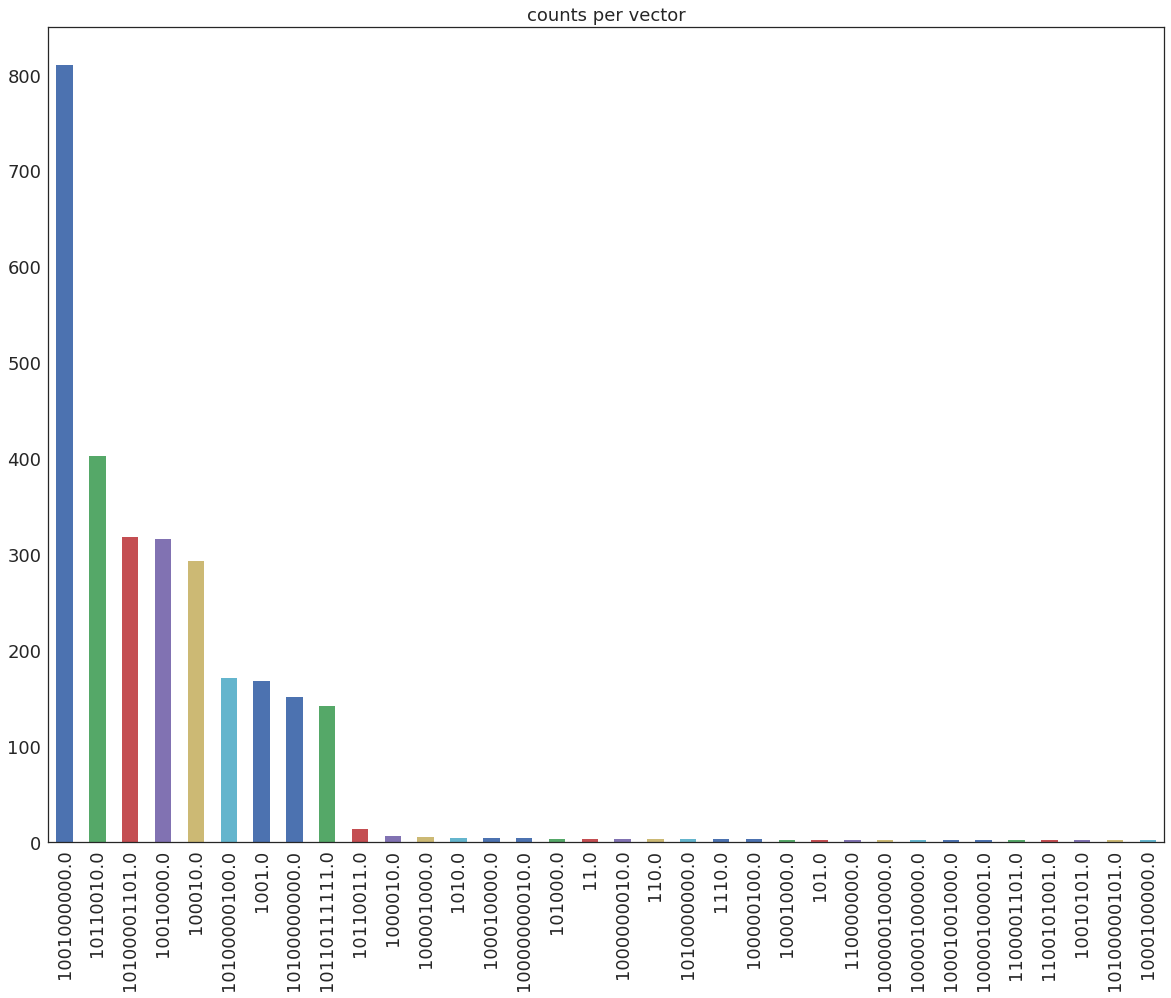

In [31]:

keep2=keep
nmut2=keep2.vector.value_counts().reset_index(name="count").query("count >1")["index"]
nmut2=keep2[keep2.vector.isin(nmut2)]
nmut2=nmut2.vector.value_counts()
#plot just part of the list
nmut2=nmut2.drop(nmut2.index[33:-1])

ax=nmut2.plot(kind="bar", title="counts per vector",figsize=(20, 15),fontsize=18)


values=nmut2.tolist()
cvec=nmut2.index.tolist()
c=0
for vvec in cvec:
    print vec_from_int_to_list(int(vvec),len(keep.full_data[10]))," : ", values[c]
    c+=1


In [32]:
def vec_from_int_to_list2(vec,size):
    vec = map(int, str(vec))
    nvec=[0]*(size-len(vec))
    nvec=nvec+vec
    return nvec


ind=16318
print "Chr ",keep.contig[ind]," ",keep.position[ind],":\n"
for line in keep.full_data[ind]:
    print line[0],line[2]

print vec_from_int_to_list2(int(keep.vector[ind]),len(keep.full_data[ind]))

Chr  3   85391588 :

HT6W45 [ 0 22  0 27]
HT6W47 [ 1 43  0  1]
HT6W48 [ 0 20  0 19]
HT6W49 [ 0 47  0  1]
HT6W54 [ 1 50  0  0]
HT6W34 [ 0 63  0  0]
HT6W63 [ 0 44  0  1]
HT6W56 [ 0 38  0  0]
HT6W38 [ 0 51  0  1]
HT6W44 [ 1 21  0  0]
HT6W57 [ 0 56  1  0]
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


## Now plot the sample color code:

In [ ]:
from PIL import Image
from random import randrange, uniform


values=nmut2.tolist()
cvec=nmut2.index.tolist()
print len(cvec)

ssize=len(keep.full_data[ind])
print ssize
########################
#####to change #######
#values=values[0:10]
#cvec=cvec[0:10]
#################

#Hight
nsamp=ssize
Hsamp=10
sep=2

#width
nvec=len(cvec)
sep_vec=10
Wsamp=10



#high=bet*2+Hsamp*nsamp+sep*(nsamp-1)
high=(sep+Hsamp)*nsamp#rows

#width=2*sep_vec+nvec*Wsamp+sep_vec*(nvec-1)
width=(sep_vec+Wsamp)*nvec#col

img = Image.new('RGB', (width,high))
#all colors - from: https://www.pinterest.com/pin/392939136215153841/
#s1=(153,0,51)   #37
s1=(0,0,0)    #45
s2=(51,255,0)   #47
s3=(255,255,0)   #48
s4=(102,102,153)   #49
s5=(204,51,255)   #54
s6=(255,102,153) #34
s7=(255,204,255)  #63
s8=(204,204,102)#56
s9=(102,204,204)#38
s10=(0,102,255)#44
s11=(255,52,160)#57


Samp_color=[s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11]
#Fill the image
arr=[]
c=0
for row in range(0,high):
    for col in range(0,width):
        #if (row<bet) or (row>high-bet) or (col<bet) or (col>width-bet):#the frame - later
        if (row%(sep+Hsamp)<sep) or (col%(sep_vec+Wsamp)<sep_vec):#in the between
            #nn=(0,0,0)
            nn=(255,255,255)
        elif (row%(sep+Hsamp)==sep) or (row%(sep+Hsamp)==0) or (col%(sep_vec+Wsamp)==sep_vec) or (col%(sep_vec+Wsamp)==0):#samp_rec
            #nn=(255,255,255)
            nn=(0,0,0)

        
        else:
            block =row/(sep+Hsamp) #which block?
            vector=col/(sep_vec+Wsamp) #which vector?
            if (vec_from_int_to_list(int(cvec[vector]),ssize)[block]==1):
                nn=Samp_color[block]
            else:
                #nn=(0,0,0)
                nn=(255,255,255)

        #    R=(randrange(0, 255))
        #    G=(randrange(0, 255))
        #    B=(randrange(0, 255))
               
        arr.append(nn)
    c+=1
    
    
img.putdata(arr,1, 0)  #pixel = value * scale + offset
img.save('image.png')


In [ ]:
## and prepare data bar to this graph:

from PIL import Image
from random import randrange, uniform


values=2
cvec=[111111111111]
print len(cvec)

ssize=len(keep.full_data[ind])
print ssize
########################
#####to change #######
#values=values[0:10]
#cvec=cvec[0:10]
#################

#Hight
nsamp=ssize
Hsamp=10
sep=2

#width
nvec=len(cvec)
sep_vec=10
Wsamp=10



#high=bet*2+Hsamp*nsamp+sep*(nsamp-1)
high=(sep+Hsamp)*nsamp#rows

#width=2*sep_vec+nvec*Wsamp+sep_vec*(nvec-1)
width=(sep_vec+Wsamp)*nvec#col

img = Image.new('RGB', (width,high))
#all colors - from: https://www.pinterest.com/pin/392939136215153841/
#all colors - from: https://www.pinterest.com/pin/392939136215153841/
s1=(0,0,0)    #45
s2=(51,255,0)   #47
s3=(255,255,0)   #48
s4=(102,102,153)   #49
s5=(204,51,255)   #54
s6=(255,102,153) #34
s7=(255,204,255)  #63
s8=(204,204,102)#56
s9=(102,204,204)#38
s10=(0,102,255)#44
s11=(255,52,160)#57


Samp_color=[s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11]
#Fill the image
arr=[]
c=0
for row in range(0,high):
    for col in range(0,width):
        #if (row<bet) or (row>high-bet) or (col<bet) or (col>width-bet):#the frame - later
        if (row%(sep+Hsamp)<sep) or (col%(sep_vec+Wsamp)<sep_vec):#in the between
            #nn=(0,0,0)
            nn=(255,255,255)
        elif (row%(sep+Hsamp)==sep) or (row%(sep+Hsamp)==0) or (col%(sep_vec+Wsamp)==sep_vec) or (col%(sep_vec+Wsamp)==0):#samp_rec
            #nn=(255,255,255)
            nn=(0,0,0)

        
        else:
            block =row/(sep+Hsamp) #which block?
            vector=col/(sep_vec+Wsamp) #which vector?
            if (vec_from_int_to_list(int(cvec[vector]),ssize)[block]==1):
                nn=Samp_color[block]
            else:
                #nn=(0,0,0)
                nn=(255,255,255)

        #    R=(randrange(0, 255))
        #    G=(randrange(0, 255))
        #    B=(randrange(0, 255))
               
        arr.append(nn)
    c+=1
    
    
img.putdata(arr,1, 0)  #pixel = value * scale + offset
img.save('img_bar.png')
